In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import time
import os

from numpy import *
from math import sqrt
from pandas import *
from datetime import datetime, timedelta

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error

from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.layers import Dense, Dropout, Bidirectional
from tensorflow.keras.layers import BatchNormalization, Embedding, TimeDistributed, LeakyReLU
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten, Conv1D, ELU, ReLU, Dropout

from matplotlib import pyplot
from pickle import load

In [3]:
X_train = np.load("/content/drive/MyDrive/Project/X_train.npy", allow_pickle=True)
y_train = np.load("/content/drive/MyDrive/Project/y_train.npy", allow_pickle=True)
X_test = np.load("/content/drive/MyDrive/Project/X_test.npy", allow_pickle=True)
y_test = np.load("/content/drive/MyDrive/Project/y_test.npy", allow_pickle=True)
yc_train = np.load("/content/drive/MyDrive/Project/yc_train.npy", allow_pickle=True)
yc_test = np.load("/content/drive/MyDrive/Project/yc_test.npy", allow_pickle=True)

In [4]:
def make_generator_model(input_dim, output_dim, feature_size) -> tf.keras.models.Model:

    model = Sequential()
    model.add(GRU(units=1024, return_sequences = True,
                  input_shape=(input_dim, feature_size), recurrent_dropout=0.2))
    model.add(GRU(units=512, return_sequences = True, recurrent_dropout=0.2))
    model.add(GRU(units=256, recurrent_dropout=0.2))
    model.add(Dense(128))
    model.add(Dense(64))
    model.add(Dense(units=output_dim))
    return model

In [5]:
def make_discriminator_model():

    cnn_net = tf.keras.Sequential()
    cnn_net.add(Conv1D(32, input_shape=(4, 1), kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(64, kernel_size=5, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(128, kernel_size=5, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Flatten())
    cnn_net.add(Dense(220, use_bias=False))
    cnn_net.add(LeakyReLU())
    cnn_net.add(Dense(220, use_bias=False, activation='relu'))
    cnn_net.add(Dense(1, activation='sigmoid'))
    return cnn_net

In [6]:
model = make_discriminator_model()

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2, 32)             128       
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 64)             10304     
                                                                 
 conv1d_2 (Conv1D)           (None, 1, 128)            41088     
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 220)               28160     
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 220)               0         
                                                                 
 dense_1 (Dense)             (None, 220)               4

In [8]:
class GAN:
    def __init__(self, generator, discriminator, opt):
        self.opt = opt
        self.lr = opt["lr"]
        self.generator = generator
        self.discriminator = discriminator
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        self.generator_optimizer = tf.keras.optimizers.Adam(lr=self.lr)
        self.discriminator_optimizer = tf.keras.optimizers.Adam(lr=self.lr)
        self.batch_size = self.opt['bs']
        self.checkpoint_dir = '../training_checkpoints'
        self.checkpoint_prefix = os.path.join(self.checkpoint_dir, "ckpt")
        self.checkpoint = tf.train.Checkpoint(generator_optimizer=self.generator_optimizer,
                                              discriminator_optimizer=self.discriminator_optimizer,
                                              generator=self.generator,
                                              discriminator=self.discriminator)

    def discriminator_loss(self, real_output, fake_output):
        real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

    def generator_loss(self, fake_output):
        return self.cross_entropy(tf.ones_like(fake_output), fake_output)

    @tf.function
    def train_step(self, real_x, real_y, yc):
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_data = self.generator(real_x, training=True)
            generated_data_reshape = tf.reshape(generated_data, [generated_data.shape[0], generated_data.shape[1], 1])
            d_fake_input = tf.concat([tf.cast(generated_data_reshape, tf.float64), yc], axis=1)
            real_y_reshape = tf.reshape(real_y, [real_y.shape[0], real_y.shape[1], 1])
            d_real_input = tf.concat([real_y_reshape, yc], axis=1)

            real_output = self.discriminator(d_real_input, training=True)
            fake_output = self.discriminator(d_fake_input, training=True)

            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

        return real_y, generated_data, {'d_loss': disc_loss, 'g_loss': gen_loss}

    def train(self, real_x, real_y, yc, opt):
        train_hist = {}
        train_hist['D_losses'] = []
        train_hist['G_losses'] = []
        train_hist['per_epoch_times'] = []
        train_hist['total_ptime'] = []

        epochs = opt["epoch"]
        for epoch in range(epochs):
            start = time.time()

            real_price, fake_price, loss = self.train_step(real_x, real_y, yc)

            G_losses = []
            D_losses = []

            Real_price = []
            Predicted_price = []

            D_losses.append(loss['d_loss'].numpy())
            G_losses.append(loss['g_loss'].numpy())

            Predicted_price.append(fake_price.numpy())
            Real_price.append(real_price.numpy())

            # Save the model every 15 epochs
            if (epoch + 1) % 15 == 0:
                tf.keras.models.save_model(generator, '/content/drive/MyDrive/Project/gen_model_3_1_%d.h5' % epoch)
                self.checkpoint.save(file_prefix=self.checkpoint_prefix + f'-{epoch}')
                print('epoch', epoch + 1, 'd_loss', loss['d_loss'].numpy(), 'g_loss', loss['g_loss'].numpy())
            # print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))
            # For printing loss
            epoch_end_time = time.time()
            per_epoch_ptime = epoch_end_time - start
            train_hist['D_losses'].append(D_losses)
            train_hist['G_losses'].append(G_losses)
            train_hist['per_epoch_times'].append(per_epoch_ptime)

        # Reshape the predicted result & real
        Predicted_price = np.array(Predicted_price)
        Predicted_price = Predicted_price.reshape(Predicted_price.shape[1], Predicted_price.shape[2])
        Real_price = np.array(Real_price)
        Real_price = Real_price.reshape(Real_price.shape[1], Real_price.shape[2])

        plt.plot(train_hist['D_losses'], label='D_loss')
        plt.plot(train_hist['G_losses'], label='G_loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        return Predicted_price, Real_price, np.sqrt(mean_squared_error(Real_price, Predicted_price)) / np.mean(
            Real_price)


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


epoch 15 d_loss 1.4444268 g_loss 0.5900654


epoch 30 d_loss 1.3808013 g_loss 0.70840037


epoch 45 d_loss 1.3819735 g_loss 0.71781343


epoch 60 d_loss 1.3861508 g_loss 0.69945896


epoch 75 d_loss 1.3862073 g_loss 0.6839571


epoch 90 d_loss 1.3793354 g_loss 0.7012951


epoch 105 d_loss 1.3788638 g_loss 0.7073771


epoch 120 d_loss 1.3873484 g_loss 0.68550247


epoch 135 d_loss 1.3853774 g_loss 0.68279505


epoch 150 d_loss 1.3841431 g_loss 0.6756181


epoch 165 d_loss 1.3627906 g_loss 0.6750452


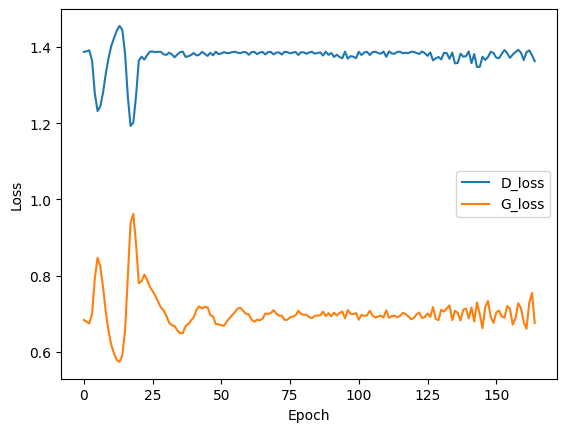

In [9]:
if __name__ == '__main__':
    input_dim = X_train.shape[1]
    feature_size = X_train.shape[2]
    output_dim = y_train.shape[1]

    ## For Bayesian
    opt = {"lr": 0.00016, "epoch": 165, 'bs': 128}

    generator = make_generator_model(X_train.shape[1], output_dim, X_train.shape[2])
    discriminator = make_discriminator_model()
    gan = GAN(generator, discriminator, opt)
    Predicted_price, Real_price, RMSPE = gan.train(X_train, y_train, yc_train, opt)

In [10]:
X_scaler = load(open('/content/drive/MyDrive/Project/X_scaler.pkl', 'rb'))
y_scaler = load(open('/content/drive/MyDrive/Project/y_scaler.pkl', 'rb'))

train_predict_index = np.load("/content/drive/MyDrive/Project/index_train.npy", allow_pickle=True)
test_predict_index = np.load("/content/drive/MyDrive/Project/index_test.npy", allow_pickle=True)

In [11]:
print("predicted price:\n", Predicted_price)

predicted price:
 [[-0.89234316]
 [-0.88848317]
 [-0.8853535 ]
 ...
 [-0.47712153]
 [-0.47791672]
 [-0.47671363]]


In [12]:
rescaled_Real_price = y_scaler.inverse_transform(Real_price)
rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_price)

In [13]:
print("rescaled predicted price:\n", rescaled_Predicted_price)

rescaled predicted price:
 [[ 3.5063915]
 [ 3.5809739]
 [ 3.6414447]
 ...
 [11.529249 ]
 [11.5138855]
 [11.537131 ]]


In [14]:
print("SHAPE rescaled predicted price\n", rescaled_Predicted_price.shape)

SHAPE rescaled predicted price
 (5881, 1)


In [15]:
predict_result = pd.DataFrame()

for i in range(rescaled_Predicted_price.shape[0]):
    y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"], index=train_predict_index[i:i+output_dim])
    predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

In [16]:
real_price = pd.DataFrame()

for i in range(rescaled_Real_price.shape[0]):
    y_train = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=train_predict_index[i:i+output_dim])
    real_price = pd.concat([real_price, y_train], axis=1, sort=False)

In [17]:
predict_result['predicted_mean'] = predict_result.mean(axis=1)
real_price['real_mean'] = real_price.mean(axis=1)

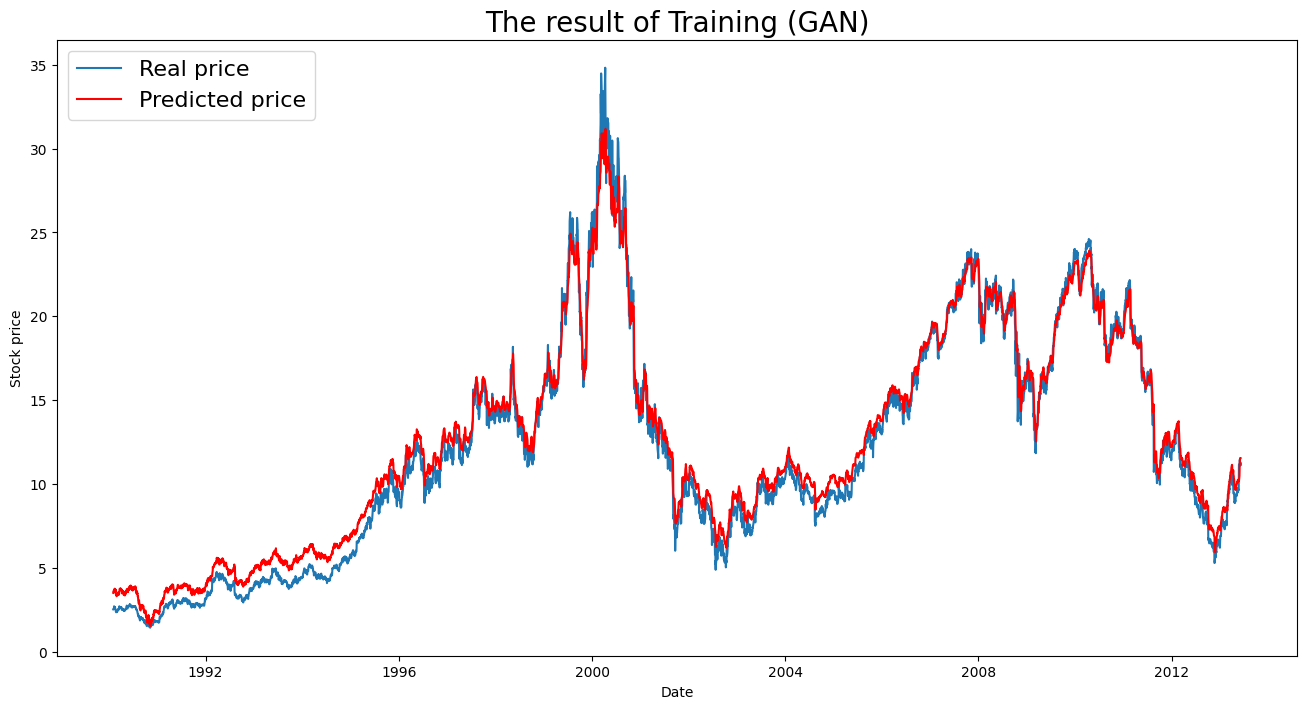

In [18]:
plt.figure(figsize=(16, 8))
plt.plot(real_price["real_mean"])
plt.plot(predict_result["predicted_mean"], color = 'r')
plt.xlabel("Date")
plt.ylabel("Stock price")
plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
plt.title("The result of Training (GAN)", fontsize=20)
plt.show()

In [19]:
predicted = predict_result["predicted_mean"]
real = real_price["real_mean"]
For_MSE = pd.concat([predicted, real], axis = 1)
RMSE = np.sqrt(mean_squared_error(predicted, real))
print('Train RMSE:', RMSE)

Train RMSE: 0.8401836301346722


In [20]:
G_model = tf.keras.models.load_model('/content/drive/MyDrive/Project/gen_model_3_1_89.h5')

In [21]:
def get_test_plot(X_test, y_test):
    # Set output steps
    output_dim = y_test.shape[1]

    # Get predicted data
    y_predicted = G_model(X_test)
    rescaled_real_y = y_scaler.inverse_transform(y_test)
    rescaled_predicted_y = y_scaler.inverse_transform(y_predicted)

    ## Predicted price
    predict_result = pd.DataFrame()
    for i in range(rescaled_predicted_y.shape[0]):
        y_predict = pd.DataFrame(rescaled_predicted_y[i], columns=["predicted_price"],
                                 index=test_predict_index[i:i + output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    ## Real price
    real_price = pd.DataFrame()
    for i in range(rescaled_real_y.shape[0]):
        y_train = pd.DataFrame(rescaled_real_y[i], columns=["real_price"], index=test_predict_index[i:i + output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    # Plot the predicted result
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color='r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of test (GAN)", fontsize=20)
    plt.show()
    plt.savefig('test_plot.png')
    # Calculate RMSE
    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    For_MSE = pd.concat([predicted, real], axis=1)
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    print('RMSE:', RMSE)

    return predict_result, RMSE

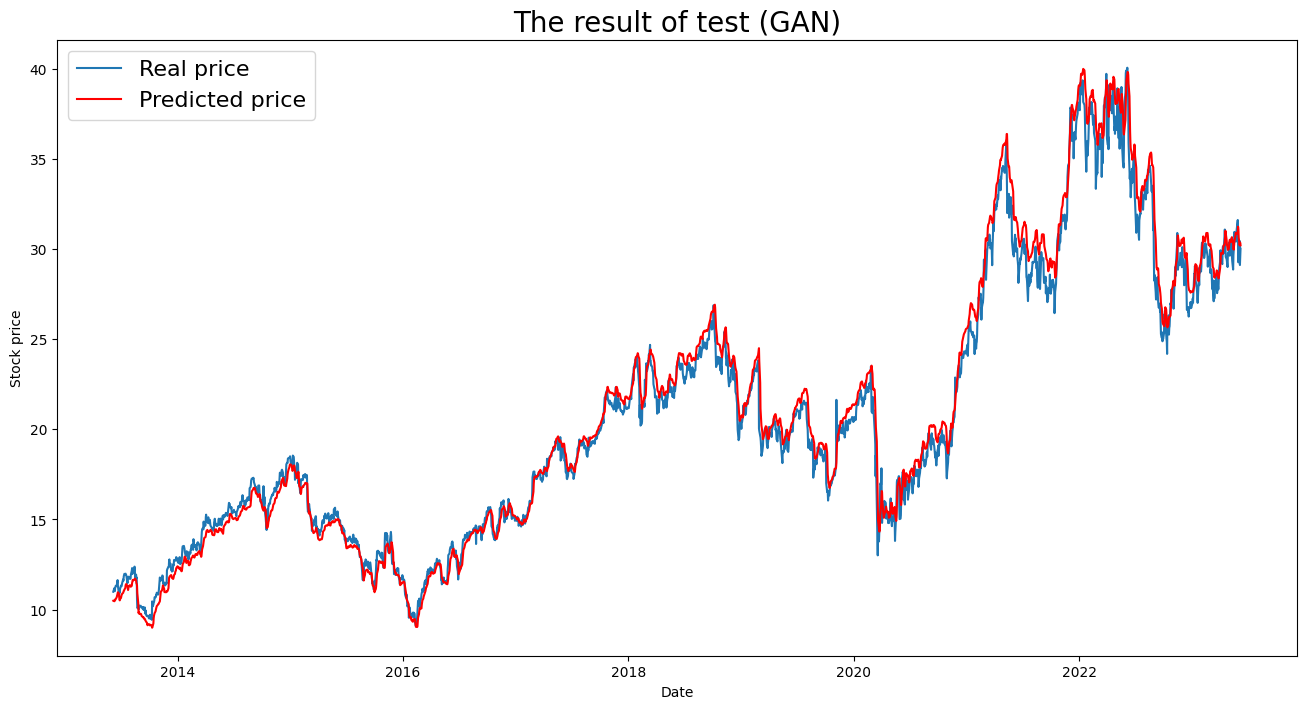

RMSE: 0.8974523831720971


<Figure size 640x480 with 0 Axes>

In [22]:
test_predicted, test_RMSE = get_test_plot(X_test, y_test)

In [23]:
def get_test_without2020_plot(X_test, y_test):
    # Set output steps
    output_dim = y_test.shape[1]

    # Get predicted data
    y_predicted = G_model(X_test)
    rescaled_real_y = y_scaler.inverse_transform(y_test)
    rescaled_predicted_y = y_scaler.inverse_transform(y_predicted)

    ## Predicted price
    predict_result = pd.DataFrame()
    for i in range(rescaled_predicted_y.shape[0]):
        y_predict = pd.DataFrame(rescaled_predicted_y[i], columns=["predicted_price"],
                                 index=test_predict_index[i:i + output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    ## Real price
    real_price = pd.DataFrame()
    for i in range(rescaled_real_y.shape[0]):
        y_train = pd.DataFrame(rescaled_real_y[i], columns=["real_price"], index=test_predict_index[i:i + output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    #drop 2020
    Input_Before = '2020-01-01'
    predict_result = predict_result.loc[predict_result.index < Input_Before]
    real_price = real_price.loc[real_price.index < Input_Before]

    # Plot the predicted result
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color='r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of test without 2020 (GAN)", fontsize=20)
    plt.show()
    plt.savefig('test_plot.png')
    # Calculate RMSE
    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    For_MSE = pd.concat([predicted, real], axis=1)
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    print('RMSE:', RMSE)

    return predict_result, RMSE

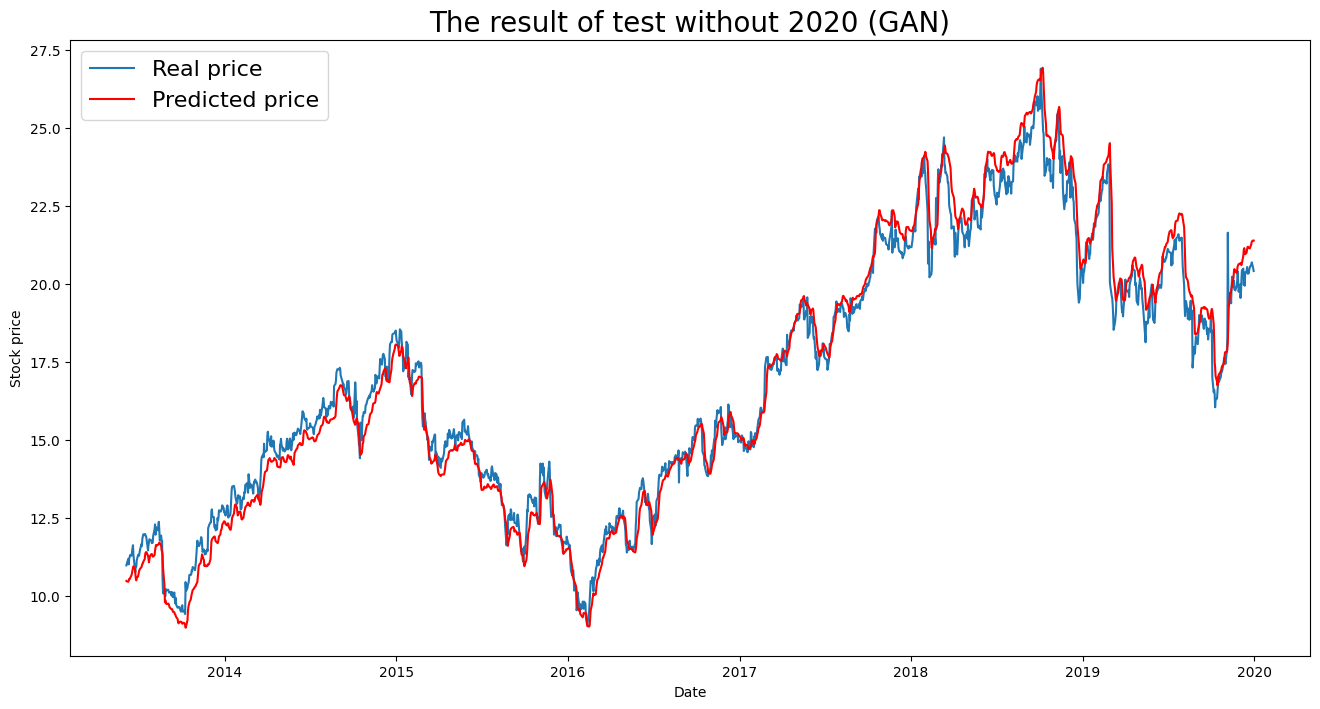

RMSE: 0.6158168203549556


<Figure size 640x480 with 0 Axes>

In [24]:
test_predicted, test_RMSE = get_test_without2020_plot(X_test, y_test)

In [25]:
# test_predicted.to_csv("/content/drive/MyDrive/Project/test_predicted.csv")